<a href="https://colab.research.google.com/github/nicolashernandez/teaching_nlp/blob/main/05_Classification_de_textes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification de textes

La **classification** consiste à attribuer une classe à chaque texte (objet, instance, point) à classer. On parle de *classification binaire* (_binary classification_) quand il y a deux classes. On parle de *classification en classes multiples* (_multiclass classification_) pour désigner la répartition d'un lot de textes entre plus de deux ensembles (ou classes). On parle de *classification multi-étiquettes* (_multi-label classification_) pour désigner les problèmes de classification où plusieurs étiquettes (classes) peuvent être assignées à chaque instance.

Reconnaître si un email est un spam, si une photo contient une voiture... sont des problèmes de classification (binaire).


# Sentiment analysis as a classification task


La tâche classique d'analyse de sentiment consiste à annoter un texte donné selon une polarité positive ou négative exprimée dans le texte.


## QUESTION

* Selon vous la tâche d'analyse de sentiment tel que définie juste au dessus peut se définir comme un problème de 1) classification binaire, 2) classification en classes multiples ou 3) en classification multi-étiquettes ?

## VOTRE REPONSE

**TODO**


## Installation et configuration de l'environnement


### Mode GPU

Quel mode d'exécution utilisez-vous (via GPU ou via CPU) ? Que vous dis le code ci-dessous ?

In [ ]:
# memory footprint support libraries/code
# https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed

def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
#

if len(GPUs) >0: 
  gpu = GPUs[0]
  printm()
else:
  print ('no GPU. Are you sure the hardware accelerator is configured to GPU? To do this go to Runtime→Change runtime type and change the Hardware accelerator to GPU.') 

Configurez votre mode d'exécution du Google Colab en mode GPU.

> To use the google colab in a GPU mode you have to make sure the hardware accelerator is configured to GPU. To do this go to Runtime→Change runtime type and change the Hardware accelerator to GPU. Sometimes, all GPUs are in use and there is no GPU available.

Une fois configuré le GPU, vérifiez l'état de la mémoire sur la carte en réexécutant le code "memory footprint" ci-dessus. Le message a-t-il changé favorablement ?

Le mode d'exécution GPU est nécessaire pour le fine-tuning de BERT ci-dessous. 

### Configuration et installation de ktrain

[ktrain](https://github.com/amaiya/ktrain) a lightweight wrapper for the deep learning library _TensorFlow Keras_ (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, ktrain is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.


Configuration de l'environnement

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

Installation de la bibliothèque ktrain

In [5]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 981 kB 58.3 MB/s 
     |████████████████████████████████| 263 kB 60.7 MB/s 
     |████████████████████████████████| 3.8 MB 51.8 MB/s 
     |████████████████████████████████| 1.3 MB 66.3 MB/s 
     |████████████████████████████████| 468 kB 62.8 MB/s 
     |████████████████████████████████| 880 kB 65.0 MB/s 
     |████████████████████████████████| 7.6 MB 55.9 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.10-py3-none-any.whl size=25312982 sha256=cf5202e209a6ec5156a9f5444f5c10580527710a6f71a1940e1cccdaa9ffa06f
  Stored in directory: /root/.cache/pip/wheels/9c/1c/1b/6df2db85720b8f5c6ea5e3ae37313cfc656f248abf910b7cfd
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=7932f025e626d1d1f091053e44554dfe237f6a78376ad1060a8cd8d405a339f2
  Stored in dire

Import de la bibliothèque ktrain

In [6]:
# Execution time 30 s
import ktrain
from ktrain import text

##  Allociné dataset

The [Allociné dataset](https://huggingface.co/datasets/allocine) is a French-language dataset for sentiment analysis. The texts are movie reviews written between 2006 and 2020 by members of the Allociné.fr community for various films. It contains 100k positive and 100k negative reviews divided into train (160k), validation (20k), and test (20k). 



### Working with a sample

**Skip this part !!**

In [ ]:
# Récupération
!wget -nc https://github.com/nicolashernandez/teaching_nlp/raw/main/data/allocine-train-10000.zip -P data
!unzip data/allocine-train-10000.zip -d data

In [ ]:
from csv import DictReader

DATA_PATH = 'data/allocine-train-10000.csv'

X = list()
Y = list()

# open file in read mode
with open(DATA_PATH, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_dict_reader = DictReader(read_obj)
    # get column names from a csv file
    column_names = csv_dict_reader.fieldnames
    print(column_names)
    for row in csv_dict_reader:
        #print(row['review'], row['positive'], row['negative'])
        X.append(row['review'])
        Y.append(row['positive'])

In [ ]:
# split the data in 
from sklearn.model_selection import train_test_split
x_train, x_valtest, y_train, y_valtest = train_test_split(X, Y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size=0.5, random_state=42)

print ('x_train', len(x_train), x_train[:10])
print ('y_train',  len(y_train), y_train[:10])
print ('x_val', len(x_val), x_val[:10])
print ('y_val',  len(y_val), y_val[:10])
print ('x_test', len(x_test))
print ('y_test',  len(y_test))


Convert a list of string into lists of int then into np.array.

This step should be skiped when running BERT



In [ ]:

import numpy as np
y_train = np.array(list(map(int, y_train)))
y_val = np.array(list(map(int, y_val)))
y_test = np.array(list(map(int, y_test)))

print ('x_train', len(x_train), x_train[:10])
print ('y_train',  len(y_train), y_train[:10])
print ('x_val', len(x_val), x_val[:10])
print ('y_val',  len(y_val), y_val[:10])
print ('x_test', len(x_test))
print ('y_test',  len(y_test))

### From huggingface datahub

In [ ]:
!pip install datasets

In [45]:
# https://huggingface.co/datasets/allocine

from datasets import load_dataset_builder
ds_builder = load_dataset_builder("allocine")

# Inspect dataset description
print(ds_builder.info.description)

# Inspect dataset features
print(ds_builder.info.features)

# get_dataset_split_names
from datasets import get_dataset_split_names
get_dataset_split_names("allocine")

# load_dataset
from datasets import load_dataset
allocine_dataset = load_dataset("allocine")
allocine_dataset
#train_dataset = load_dataset("allocine", split="train")

 Allocine Dataset: A Large-Scale French Movie Reviews Dataset.
 This is a dataset for binary sentiment classification, made of user reviews scraped from Allocine.fr.
 It contains 100k positive and 100k negative reviews divided into 3 balanced splits: train (160k reviews), val (20k) and test (20k).

{'review': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'], id=None)}


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})

#### Raw format

**Go to the pandas dataframe format and eventually come back latter if need it...**

In [48]:
x_train = allocine_dataset['train']['review']
y_train = allocine_dataset['train']['label']
x_val = allocine_dataset['validation']['review']
y_val = allocine_dataset['validation']['label']
x_train = allocine_dataset['train']['review']
y_train = allocine_dataset['train']['label']
x_test = allocine_dataset['test']['review']
y_test = allocine_dataset['test']['label']

In [49]:
print ('x_train', len(x_train), x_train[:10])
print ('y_train',  len(y_train), y_train[:10])
print ('x_val', len(x_val), x_val[:10])
print ('y_val',  len(y_val), y_val[:10])
print ('x_test', len(x_test))
print ('y_test',  len(y_test))

x_train 160000 ['Si vous cherchez du cinéma abrutissant à tous les étages,n\'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via sa filière EuropaCorp ont de quoi faire naître la moquerie.Paris y est encore une fois montrée comme une capitale exotique,mais attention si l\'on se dirige vers la banlieue,on y trouve tout plein d\'intégristes musulmans prêts à faire sauter le caisson d\'une ambassadrice américaine.Nauséeux.Alors on se dit qu\'on va au moins pouvoir apprécier la déconnade d\'un classique buddy-movie avec le jeune agent aux dents longues obligé de faire équipe avec un vieux lou complètement timbré.Mais d\'un côté,on a un Jonathan Rhys-meyers fayot au possible,et de l\'autre un John Travolta en total délire narcissico-badass,crâne rasé et bouc proéminent à l\'appui.Sinon,il n\'y a aucun scénario.Seulement,des poursuites débiles sur l\'autoroute,Travolta qui étale 10 mecs à l\'arme blanch

Convert a list of string into lists of int then into np.array.

This step should be skiped when running BERT



In [ ]:
import numpy as np
y_train = np.array(list(map(int, y_train)))
y_val = np.array(list(map(int, y_val)))
y_test = np.array(list(map(int, y_test)))

print ('x_train', len(x_train), x_train[:10])
print ('y_train',  len(y_train), y_train[:10])
print ('x_val', len(x_val), x_val[:10])
print ('y_val',  len(y_val), y_val[:10])
print ('x_test', len(x_test))
print ('y_test',  len(y_test))

#### Pandas DataFrame format

In [51]:
import pandas as pd

# Create DataFrame
def huggingface_dataset_split_to_dataframe (huggingface_dataset_split):
  df = pd.DataFrame(huggingface_dataset_split)
  # https://github.com/amaiya/ktrain/blob/master/examples/text/ArabicHotelReviews-nbsvm.ipynb
  df['label'] = df['label'].apply(lambda x: 'negative' if x == 0 else 'positive')
  df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
  df = train_df[['review', 'negative', 'positive']]
  return df

train_df = huggingface_dataset_split_to_dataframe(allocine_dataset['train'])
val_df = huggingface_dataset_split_to_dataframe(allocine_dataset['validation'])
test_df = huggingface_dataset_split_to_dataframe(allocine_dataset['test'])

train_df.head()

,review,negative,positive
0,Si vous cherchez du cinéma abrutissant à tous ...,1,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",1,0
2,"Et si, dans les 5 premières minutes du film, l...",1,0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,1,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",0,1


## Fonctionnement de ktrain


Pour réaliser cette tâche de classification nous allons utiliser la bibliothèque ktrain pour faire un apprentissage par transfert.

Les étapes sont les suivantes
1. chargement des données avec application d'un prétraitement défini à la volée
2. construction d'un modèle de classification sur la base d'un modèle pré-entraîné spécifié
3. récupération d'une instance du modèle pour la personnalisation de celui-ci
4. recherche d'un bon taux d'apprentissage
5. entraînement du classifieur i.e. personnalisation du modèle de base à l'aide d'un taux d'apprentissage défini
6. utilisation du nouveau modèle

*ETAPE 1 :* 

Le type de pré-traitement est fonction du modèle pré-entraîné spécifié.

*ETAPE 2 :*

ktrain vient avec quelques modèles pré-entraînés packagés. Pour les connaître, exécutez : 

In [23]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


Vous connaissez **fasttext**.

[**NBSVM**](https://medium.com/@asmaiya/a-neural-implementation-of-nbsvm-in-keras-d4ef8c96cb7c) is an approach to text classification proposed by [Wang and Manning](https://www.aclweb.org/anthology/P12-2018) that takes a linear model such as SVM (or logistic regression) and infuses it with Bayesian probabilities by replacing word count features with Naive Bayes log-count ratios. Despite its simplicity, NBSVM models have been shown to be both fast and powerful across a wide range of different text classification datasets. 
Keras offers a NBSVM model implemented as a neural network using two embedding layers. The first stores the Naive Bayes log-count ratios. The second stores learned weights (or coefficients) for each feature (i.e., word) in this linear model. The prediction, then, is simply the dot product of these two vectors.

**BERT** (_Bidirectional Encoder Representations from Transformers_), proposé par [Google AI Language](https://arxiv.org/pdf/1810.04805.pdf) est un encodeur bidirectionnel qui applique un modèle d'attention Transformers à la modélisation du language (_language modeling_). Il représente l'état de l'art.
Les Transformers sont un mécanisme d'attention qui apprennent les relations contextuelles entre les mots dans un texte.


Il est possible d'[**encapsuler les modèles Transformers du site _hugging face_**](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb). _hugging face_ diffuse les [modèles Transformers pré-entraînés "officiels"](https://huggingface.co/transformers/pretrained_models.html) ainsi que les [modèles Transformers construits par la communauté](https://huggingface.co/models).


*ETAPE 4 :*


Le **taux d'apprentissage (_learning rate_)** est un hyperparamètre qui contrôle combien le modèle doit changer en réponse à l'erreur estimée à chaque fois que les poids du modèles sont mis à jour. Choisir un 'lr' trop petit conduit à une longue phase d'entraînement qui peut resté bloquée. Choisir un 'lr' trop grand conduit à un apprentissage sous-optimal des poids et à une instabilité du processus d'entraînement. 

## FastText



*ETAPE 1 :* 

Les méthodes [`texts_from_csv`](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_csv) ou [`texts_from_df`](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_df) charge le corpus, normalise les documents (définit un préprocesseur réutilisable), et découpe la collection en données d'entraînement et données de validation (à moins que des données de validation soient passées en argument).

Cette étape est commune aux modèles FastText et NBSVM (`preprocess_mode='standard'`). BERT utilise son propre tokenizer. Il faudra faire un pré-traitement dédié (`preprocess_mode='bert'`).

```
* train_filepath(str): file path to training CSV
* text_column(str): name of column containing the text
* label_column(list): list of columns that are to be treated as labels
* val_filepath(string): file path to test CSV.  If not supplied, 10% of documents in training CSV will be used for testing/validation.
* max_features(int): max num of words to consider in vocabulary ; Note: This is only used for preprocess_mode='standard'.
* maxlen(int): each document can be of most <maxlen> words. 0 is used as padding ID.
* ngram_range(int): size of multi-word phrases to consider e.g., 2 will consider both 1-word phrases and 2-word phrases limited by max_features
* preprocess_mode (str):  Either 'standard' (normal tokenization) or one of {'bert', 'distilbert'} tokenization and preprocessing for use with                BERT/DistilBert text classification model.
```



        
  

In [54]:
# fasttext
#NUM_WORDS = 50000
#MAXLEN = 150
#NGRAMS_SIZE = 1# 1 # 8 minutes avec 2 pour 10000 examples

# nbsvm 
#NUM_WORDS = 80000
#MAXLEN = 2000
#NGRAMS_SIZE = 3

(x_train, y_train), (x_val, y_val), preproc = text.texts_from_df (train_df, 
                                                                   'review', # name of column containing review text
                                                                   label_columns=['negative', 'positive'],
                                                                   val_df=val_df, # if None, 10% of data will be used for validation
                                          #max_features=NUM_WORDS, 
                                          #maxlen=MAXLEN,
                                          #ngram_range=NGRAMS_SIZE,
                                          preprocess_mode='standard' # default
                                          )



['negative', 'positive']
   negative  positive
0         1         0
1         1         0
2         1         0
3         1         0
4         0         1
['negative', 'positive']
   negative  positive
0         1         0
1         1         0
2         1         0
3         1         0
4         0         1
language: fr
Word Counts: 186307
Nrows: 160000
160000 train sequences
train sequence lengths:
	mean : 87
	95percentile : 241
	99percentile : 303
x_train shape: (160000,400)
y_train shape: (160000, 2)
Is Multi-Label? False
160000 test sequences
test sequence lengths:
	mean : 87
	95percentile : 241
	99percentile : 303
x_test shape: (160000,400)
y_test shape: (160000, 2)


Observons les 5 premières des données prétraitées. `x_` représente la donnée et `y_` la classe. On note que les données ont été transformées. Chaque mot est remplacé par un identifiant. On note que la classe est décrite par 2 colonnes avec deux codes "1 0" et "0 1".

In [55]:
print ('x_train', x_train[:5])
print ('y_train', y_train[:5])

x_train [[    0     0     0 ...    47  2583  2509]
 [    0     0     0 ...  1221     2 10399]
 [    0     0     0 ...   907     1  1085]
 [    0     0     0 ...   177   150    91]
 [    0     0     0 ...   423    12  3444]]
y_train [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


*ETAPE 2 et 3:* 


In [56]:
# Build and return a text classification model https://amaiya.github.io/ktrain/text/index.html#ktrain.text.text_classifier
model = text.text_classifier('fasttext', (x_train, y_train), preproc=preproc)

# Returns a Learner instance that can be used to tune and train Keras models https://amaiya.github.io/ktrain/index.html#ktrain.get_learner
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_val, y_val))

Is Multi-Label? False
compiling word ID features...
maxlen is 400
done.


*ETAPE 4 :* 

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
5000/5000 [==============================] - 9s 2ms/step - loss: 0.8657 - accuracy: 0.5574


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


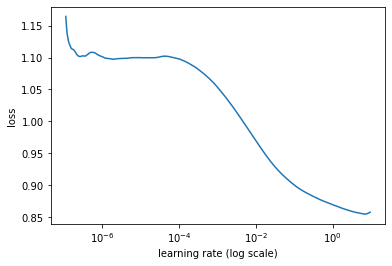

In [57]:
# recherche d'un bon taux d'apprentissage 
learner.lr_find()
learner.lr_plot()

*ETAPE 5 :* 

[autofit](https://amaiya.github.io/ktrain/core.html#ktrain.core.Learner.autofit)
Automatically train model using a default learning rate schedule shown to work well in practice.  By default, this method currently employs a triangular learning rate policy (https://arxiv.org/abs/1506.01186).  
During each epoch, this learning rate policy varies the learning rate from lr/10 to lr and then back to a low learning rate that is near-zero. 
If epochs is None, then early_stopping and reduce_on_plateau are atomatically
set to 6 and 3, respectively.


#### QUESTION : training

* Sur le graph ci-dessus, repérez approximativement la puissance n de 1/10^n où la chute de la loss devient importante. Testez avec cette valeur comme learning rate, observez votre performance (accuracy) sur le train et le val.

Dans l'extrait de log ci-dessous, loss et accuracy concerne le corpus de train tandis que  val_loss et val_accuracy le corpus de validation.
```
282/282 [==============================] - 7s 25ms/step - loss: 0.1105 - accuracy: 0.9566 - val_loss: 0.3318 - val_accuracy: 0.8911
```
* Est-ce normal d'observer un écart d'accuracy entre le train et le val ?
* Stoquez le score obtenu en dernière étape, et relancez le finetuning sans changer le paramétrage. Obtenez-vous les mêmes résultats ? Pourquoi ? La réponse est à chercher dans l'initiatilisation des poids du réseau neuronal.
* Volontairement tester des lr avec d'autres puissances de 10 (0.1, 0.01, 0.001, 0.0001). Est-ce que cela marche mieux ? Attention, suivant votre choix de lr l'entraînement peut prendre quelques minutes à au moins 1h....

Mon meilleur score est `loss: 0.1615 - accuracy: 0.9384 - val_loss: 0.2864 - val_accuracy: 0.8931` (non c'est plus vrai) et vous ?



In [ ]:
# wi all allocine training dataset (8 minutes) 
learner.autofit(0.01)
# Epoch 16/1024
# 4491/4500 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9418Restoring model weights from the end of the best epoch: 11.
# 4500/4500 [==============================] - 25s 6ms/step - loss: 0.1539 - accuracy: 0.9418 - val_loss: 0.2173 - val_accuracy: 0.9206
# Epoch 16: early stopping

# wi all allocine training dataset (at least one hour run) 
#learner.autofit(0.00001)
# Epoch 129/1024
# 4497/4500 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9135Restoring model weights from the end of the best epoch: 124.
# 4500/4500 [==============================] - 29s 6ms/step - loss: 0.2197 - accuracy: 0.9135 - val_loss: 0.2058 - val_accuracy: 0.9204
# Epoch 129: early stopping

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
5000/5000 [==============================] - 37s 7ms/step - loss: 0.3701 - accuracy: 0.8366 - val_loss: 0.2100 - val_accuracy: 0.9216
Epoch 2/1024
5000/5000 [==============================] - 36s 7ms/step - loss: 0.2841 - accuracy: 0.8859 - val_loss: 0.1951 - val_accuracy: 0.9320
Epoch 3/1024
5000/5000 [==============================] - 50s 10ms/step - loss: 0.2643 - accuracy: 0.8951 - val_loss: 0.1778 - val_accuracy: 0.9361
Epoch 4/1024
5000/5000 [==============================] - 41s 8ms/step - loss: 0.2523 - accuracy: 0.9001 - val_loss: 0.1701 - val_accuracy: 0.9404
Epoch 5/1024
5000/5000 [==============================] - 39s 8ms/step - loss: 0.2417 - accuracy: 0.9052 - val_loss: 0.1572 - val_accuracy: 0.9443
Epoch 6/1024
5000/5000 [==============================] - 41s 8ms/step - loss: 0.

#### VOTRE REPONSE

**TODO**

*ETAPE 6 :* Le code ci-dessous permet d'utiliser le modèle. 

In [36]:
predictor = ktrain.get_predictor(learner.model, preproc)

data = [ "Ce film était horrible ! L'intrigue était ennuyeuse. Le jeu d'acteur était correct, cependant.",
         "Le film est vraiment nul. Je veux qu'on me rende mon argent.",
        "Quelle belle comédie romantique. 10/10 à revoir !"]

# Makes predictions for a list of strings where each string is a document or text snippet.
print (predictor.predict(data))

# If return_proba is True, returns probabilities of each class.
print (predictor.predict(data,  return_proba=True))

['negative', 'negative', 'positive']
[[9.9996245e-01 3.7598063e-05]
 [9.9657214e-01 3.4278736e-03]
 [3.4658754e-01 6.5341240e-01]]


#### QUESTION : évaluation qualitative légère

* Tester le modèle. Arrivez-vous à piéger le modèle ? Avec quelle phrase (donnez le code)

#### VOTRE REPONSE

**TODO**

### QUESTION : Evaluation quantitative

Prediction sur le corpus de test

In [ ]:
y_hyp = predictor.predict(allocine_dataset['test']['review'])



[SemEval 2022 isarcasmeval task](https://sites.google.com/view/semeval2022-isarcasmeval) used the F1-score for the sarcastic class. This metric should not be confused with the regular macro-F1. Here we choose the positive class for illustration

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1_positive = f1_score(y_test, y_hyp, average = "binary", pos_label = 1)

#OR
#p_score_positive = precision_score(y_test, y_hyp, average = "binary", pos_label = 1)
#r_score_positive = recall_score(y_test, y_hyp, average = "binary", pos_label = 1)
#f1_positive = (2*p_score_positive*r_score_positive)/(p_score_positive +r_score_positive)

We will use regular F1 score

In [ ]:
allocine_dataset['test']['review']
y_test = allocine_dataset['test']['label']
f1 = f1_score(y_test, y_hyp)
f1

[Theophile Blard rapporte des performances avec différents modèles (CamemBERT, RNN, TF-IDF + LogReg, CNN, fastText (unigrams)) sur le dataset Allociné](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert). Comment vous positionnez-vous par rapport à ses résultats ?   

## NBSVM

Le code ci-dessous utilise le même pré-traitement que précédemment et applique un modèle neuronal plus "simple" que fasttext.  

In [37]:
# load an NBSVM model
model = text.text_classifier('nbsvm', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_val, y_val))

# fine tune
LEARNING_RATE = 0.01
learner.autofit(LEARNING_RATE)
# Epoch 6/1024
#4498/4500 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9544Restoring model weights from the end of the best epoch: 1.
#4500/4500 [==============================] - 24s 5ms/step - loss: 0.1264 - accuracy: 0.9544 - val_loss: 0.2677 - val_accuracy: 0.9161
#Epoch 6: early stopping

# Finally, we will fit our model using and [SGDR learning rate](https://github.com/amaiya/ktrain/blob/master/example-02-tuning-learning-rates.ipynb) schedule by invoking the fit method with the cycle_len parameter (along with the cycle_mult parameter).
# learner.fit(0.001, 3, cycle_len=1, cycle_mult=2)


Is Multi-Label? False
compiling word ID features...
maxlen is 400
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-30000
rows: 30001-40000
rows: 40001-50000
rows: 50001-60000
rows: 60001-70000
rows: 70001-80000
rows: 80001-90000
rows: 90001-100000
rows: 100001-110000
rows: 110001-120000
rows: 120001-130000
rows: 130001-140000
rows: 140001-144000
computing log-count ratios...
done.
early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Epoch 1/1024
4500/4500 [==============================] - 22s 5ms/step - loss: 0.2423 - accuracy: 0.9141 - val_loss: 0.2210 - val_accuracy: 0.9214
Epoch 2/1024
4500/4500 [==============================] - 21s 5ms/step - loss: 0.1881 - accuracy: 0.9321 - val_loss: 0.2428 - val_accuracy: 0.9193
Epoch 3/1024
4496/4500 [============================>.] - ETA: 0s - loss: 0.1757

#### QUESTION

* Le modèle nbsvm est-il plus performant que le précédent sur les données de validations ? Vous pouvez tester aussi différents learning rate.

## BERT 

L'usage du modèle bert requiert que l'on change le prétraitement des données en entrée. Le code suivant réalise le prétraitement, charge un modèle bert et lance la personnalisation (fine tuning) sur 1 cycle avec taux d'apprentissage fixé.


#### QUESTION
* Exécutez le code en observant l'occupation de la RAM et attendez jusqu'à voir le temps prévisionnel s'afficher. Etes-vous choqué par le temps affiché ? Bert est très gros. Il requiert un peu de temps...
* Stoppez l'exécution dans la cellule, et tentez de changer la taille du batch_size (quantité de données traitées en même temps). Vous pouvez tester 128 et 12 comme valeurs. Ne lachez pas la barre de la RAM des yeux. Ça passe ? Quel problème rencontrez-vous ? 
* Passez à la suite...

In [38]:
# ETAPE 1 
(x_train, y_train), (x_val, y_val), preproc = text.texts_from_df (train_df, 
                      'review',
                      label_columns = ["negative", "positive"],
                      val_df= val_df, # if None, 10% of data will be used for validation
                      ##max_features=NUM_WORDS, 
                      #maxlen=MAXLEN,
                      preprocess_mode='bert' 
                      )

['negative', 'positive']
        negative  positive
3661           0         1
72776          1         0
96097          0         1
129808         1         0
106107         1         0
['negative', 'positive']
        negative  positive
131304         1         0
1761           1         0
15952          1         0
117463         1         0
43800          0         1
downloading pretrained BERT model (multi_cased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: fr


Is Multi-Label? False
preprocessing test...
language: fr


In [39]:
# ETAPE 2 et 3
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_val, y_val), 
                             batch_size=6)
# ETAPE 5
learner.fit_onecycle(2e-5, 1)

Is Multi-Label? False
maxlen is 400
done.


begin training using onecycle policy with max lr of 2e-05...
  318/24000 [..............................] - ETA: 4:11:52 - loss: 0.6092 - accuracy: 0.6667

KeyboardInterrupt: ignored

## Modèle "à la bert" issu de hugging face

On va tester un modèle encore plus léger 'distilbert-base-uncased'. Exécutez toutes les cellules de code ci-dessous. Laissez tourner et répondez aux questions.

 

In [41]:
x_train = allocine_dataset['train']['review']
y_train = allocine_dataset['train']['label']
x_val = allocine_dataset['validation']['review']
y_val = allocine_dataset['validation']['label']
x_train = allocine_dataset['train']['review']
y_train = allocine_dataset['train']['label']
x_test = allocine_dataset['test']['review']
y_test = allocine_dataset['test']['label']

[array([[  101,   178,   112, ...,     0,     0,     0],
        [  101, 12653, 28341, ...,     0,     0,     0],
        [  101, 11681, 58817, ...,     0,     0,     0],
        ...,
        [  101,   192, 33646, ...,     0,     0,     0],
        [  101, 10231, 15975, ...,     0,     0,     0],
        [  101, 10322, 11639, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [40]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
#MODEL_NAME = 'albert-base-v2'
CLASS_NAMES = ["negative", "positive"]

t = text.Transformer(MODEL_NAME, maxlen=500, class_names=CLASS_NAMES)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_val, y_val)
#print (type(trn))
#x_train, y_train = trn
#x_test, y_test = val  
model = t.get_classifier()
# batch_size (int):              Batch size to use in training. default:32  
#learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6) # 128 dépend de la ram dispo 13 Go par défaut
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=12)



Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessing train...


ValueError: ignored

In [ ]:
learner.fit_onecycle(0.01, 1)
#learner.fit_onecycle(8e-5, 4)
#8e-5 = 8 + 10^(-5)

#### QUESTION
* Quelle performance j'obtiens comparativement aux 2 modèles précédents nbsvm et fasttext ?
* Quelles risques je prends à ne pas réaliser les mêmes prétraitements ou  normalisations (voire utiliser des outils différents pour réaliser les mêmes prétraitements ou normalisations supposées) que ceux réalisés sur les corpus ayant servis à construire les modèles ? 
* En résumé, en mettant dans la balance les questions de performance, les questions de taille de modèles, de temps de "fine-tuning"... quelles conclusions faites-vous de l'usage des modèles simples vs les modèles plus complexes à la BERT ?

Si le code tourne toujours passez à la question suivante pour gagner du temps...

#### VOTRE REPONSE

**TODO**


# Devoir à rendre 
[Theophile Blard rapporte des performances avec différents modèles (CamemBERT, RNN, TF-IDF + LogReg, CNN, fastText (unigrams)) sur le dataset Allociné](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert). 

Arriverez-vous à faire mieux ?

Bien entendu vous avez le droit de choisir les modèles et leur configuration.

Explorez au choix un ou plusieurs des thèmes suivants
- data augmentation
- model ensembling 

Ecrivez un rapport d'expériences.

## Topics

### Data augmentation in NLP
TextAttack is a Python framework for adversarial attacks, adversarial training, and [data augmentation in NLP](https://textattack.readthedocs.io/en/latest/2notebook/3_Augmentations.html).

Here some hints for [multi-language attacks](https://textattack.readthedocs.io/en/latest/2notebook/Example_4_CamemBERT.html)

### Model ensembling 

- Train/fine-tune multiple models from various architectures and/or dataset folds
- Then ensemble them by voting mechanism or something else

## VOTRE REPONSE

**TODO**

# Références
* Text Classification Example: Sentiment Analysis with IMDb Movie Reviews¶ https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb
* https://nbviewer.org/github/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb
* ktrain examples of Binary text Classification (Sentiment Analysis with IMDb Movie Reviews) with a nbsvm model (also a bit of bert)  and 
Multi-Label Text Classification (toxic comments) with fasttext https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb
* Text Classification with Hugging Face Transformers in ktrain https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb
* ktrain api documentation https://amaiya.github.io/ktrain/
* Evaluation of various models (CamemBERT, RNN, TF-IDF + LogReg, CNN, fastText (unigrams)) on allocine dataset https://github.com/TheophileBlard/french-sentiment-analysis-with-bert
* The Allociné dataset is a French-language dataset for sentiment analysis. The texts are movie reviews written between 2006 and 2020 by members of the Allociné.fr community for various films. It contains 100k positive and 100k negative reviews divided into train (160k), validation (20k), and test (20k). 
https://huggingface.co/datasets/allocine
* Amazon reviews for three product categories: books, DVD, and music. Each sample contains a review text and the associated rating from 1 to 5 stars. Reviews rated above 3 is labeled as positive, and those rated less than 3 is labeled as negative. https://github.com/getalp/Flaubert/tree/master/flue
* Twitter API between May and September 2018. The sentiment was generated thanks to AWS Comprehend API. For Spanish and French, tweets were first translated to English using Google Translate, and then analyzed with AWS Comprehend. https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/
* French dataset for sentiment analysis (Data translated from English to French).  A collection of over 1.5 Million tweets data translated to French, with their sentiment. The data has two columns, polarity and status https://github.com/gamebusterz/French-Sentiment-Analysis-Dataset
* English Classification datasets https://ludwig.ai/latest/examples/text_classification/